# Simplest Autoencoder 

In [3]:
import jax
import numpy as np
import jax.numpy as jnp
import optax
from sklearn import datasets
from matplotlib import pyplot as plt

In [5]:
digits = datasets.load_digits()
x_data, y_data = digits.data, digits.target
x_data = x_data/16.0

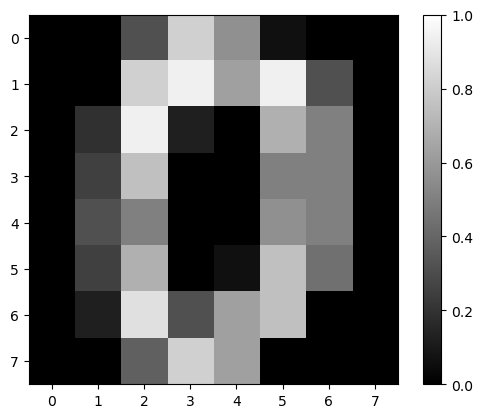

In [6]:
plt.imshow(x_data[0].reshape(8, 8), cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [7]:
input_dim = 64
hidden_dim = 8
bottleneck_dim=2
output_dim = input_dim

In [8]:
params = {
    "layer_1": {
        "W": np.random.normal(size=(input_dim, hidden_dim)) / np.sqrt(input_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_2": {
        "W": np.random.normal(size=(hidden_dim, hidden_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_3": {
        "W": np.random.normal(size=(hidden_dim, bottleneck_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(bottleneck_dim,)),
    },
    "layer_4": {
    "W": np.random.normal(size=(bottleneck_dim, hidden_dim)) / np.sqrt(bottleneck_dim),
    "b": np.zeros(shape=(hidden_dim,)),
    },
    "layer_5": {
        "W": np.random.normal(size=(hidden_dim, output_dim)) / np.sqrt(hidden_dim),
        "b": np.zeros(shape=(output_dim,)),
    },
}

In [9]:
def predict_fn(params, X):
    X0 = X
    # remember, * is an elementwise multiply, whereas @ is a matrix multiply.
    X1 = jax.nn.relu(X0 @ params["layer_1"]["W"] + params["layer_1"]["b"])
    X2 = jax.nn.relu(X1 @ params["layer_2"]["W"] + params["layer_2"]["b"])
    X3 = X2 @ params["layer_3"]["W"] + params["layer_3"]["b"]
    X4 = jax.nn.relu(X3 @ params["layer_4"]["W"] + params["layer_4"]["b"])
    X5 = jax.nn.sigmoid(X4 @ params["layer_5"]["W"] + params["layer_5"]["b"])
    return {'reconstruct': X5, 'bottleneck': X3}

def loss_fn(params, X):
    reconstruct_X = predict_fn(params, X)['reconstruct']
    loss = -(X * jnp.log(reconstruct_X) + (1 - X) * jnp.log(1 - reconstruct_X))
    return jnp.mean(loss)

In [10]:
step_size = 0.01
total_steps = 3000

# We use an optimizer called Adam here.
# We won't go into detail, but think of it as "fast gradient descent"
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

grad_loss_fn = jax.grad(loss_fn)
grad_loss_fn = jax.jit(grad_loss_fn)

for i in range(total_steps):
    idxs = np.random.randint(low=0, high=x_data.shape[0], size=32)
    x_batch = x_data[idxs]
    # Remember, we compute gradients of the *first* argument, which is params.
    grad = grad_loss_fn(params, x_batch)
    update, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, update)

    # We print the loss every 100 steps
    if i % 100 == 0:
        loss_val = loss_fn(params, x_data)
        print("Step:", i, "Loss:", loss_val)

Step: 0 Loss: 0.69490576
Step: 100 Loss: 0.59552056
Step: 200 Loss: 0.4859081
Step: 300 Loss: 0.4381206
Step: 400 Loss: 0.42386225
Step: 500 Loss: 0.41987726
Step: 600 Loss: 0.4176099
Step: 700 Loss: 0.41586015
Step: 800 Loss: 0.41409352
Step: 900 Loss: 0.41227502
Step: 1000 Loss: 0.40997604
Step: 1100 Loss: 0.40716404
Step: 1200 Loss: 0.40385583
Step: 1300 Loss: 0.40073782
Step: 1400 Loss: 0.39808017
Step: 1500 Loss: 0.39576432
Step: 1600 Loss: 0.39378914
Step: 1700 Loss: 0.39217877
Step: 1800 Loss: 0.3908444
Step: 1900 Loss: 0.38946182
Step: 2000 Loss: 0.38863766
Step: 2100 Loss: 0.3873524
Step: 2200 Loss: 0.38641444
Step: 2300 Loss: 0.3853746
Step: 2400 Loss: 0.384499
Step: 2500 Loss: 0.38356078
Step: 2600 Loss: 0.38265672
Step: 2700 Loss: 0.38155562
Step: 2800 Loss: 0.38091528
Step: 2900 Loss: 0.3799201


In [11]:
predict_vals = predict_fn(params, x_data)

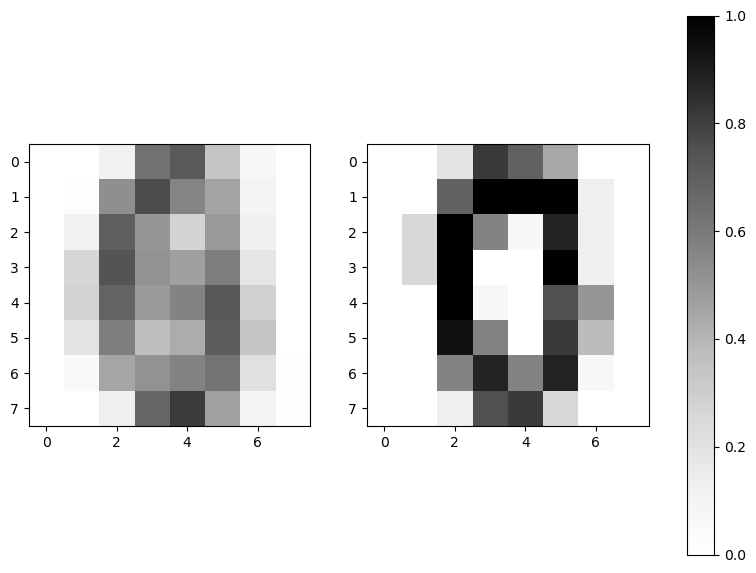

In [12]:
EXAMPLE_NUMBER = 20

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))
img0 = ax[0].imshow(predict_vals['reconstruct'][EXAMPLE_NUMBER].reshape(8, 8), vmin=0, vmax=1, cmap="Greys")
img1 = ax[1].imshow(x_data[EXAMPLE_NUMBER].reshape(8, 8), vmin=0, vmax=1, cmap="Greys")
fig.colorbar(img0, ax=ax)
plt.show()

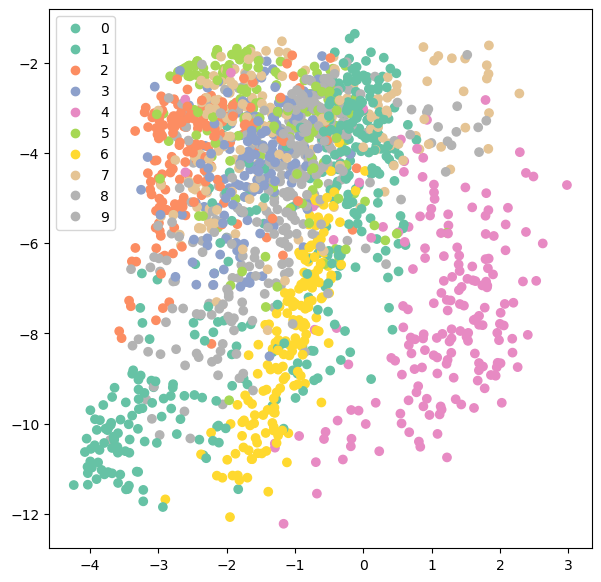

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))
scatter = ax.scatter(predict_vals['bottleneck'][:, 0], predict_vals['bottleneck'][:, 1], c=y_data, cmap="Set2")
ax.legend(handles=scatter.legend_elements()[0], labels=list(digits['target_names']))
plt.show()